# NA4AI - set2
**Author: Adriana Bukała**

**Index: 394064**

As always, we will start with loading important packages.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

We will set random seed, so our results are reproducible.

In [2]:
np.random.seed(256)

Then, we need to define our target function $f(x, y)$ and helper function for computing numerical derivatives.

In [3]:
def f(x, y):
    """Function defined in homework description."""
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def derivative(f, vs, h, direction):
    """Compute a partial numerical derivative."""
    x, y = vs
    
    if direction == 'x':
        return (f(x + h, y) - f(x, y)) / h
    elif direction == 'y':
        return (f(x, y + h) - f(x, y)) / h
    else:
        raise Exception('Direction should be x or y.')

Let's take a look at our data by randomly intializing some points and plotting results.

In [4]:
n_points = 100

In [5]:
xs = np.linspace(-5, 5, n_points)
ys = np.linspace(-5, 5, n_points)
vs = np.meshgrid(xs, ys)
h = 1 / n_points

In [6]:
gradx = derivative(f, vs, h, 'x')
grady = derivative(f, vs, h, 'y')

In [7]:
xsf, ysf = vs

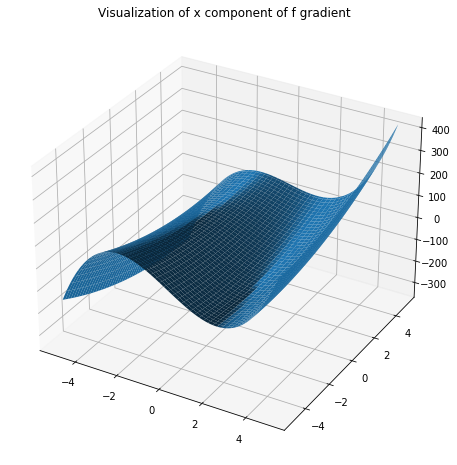

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xsf, ysf, gradx)
ax.set_title('Visualization of x component of f gradient')
plt.show()

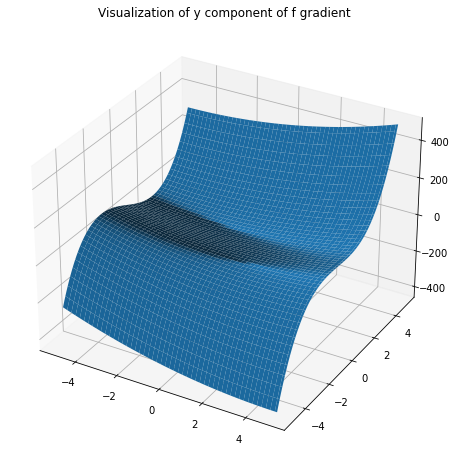

In [9]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xsf, ysf, grady)
ax.set_title('Visualization of y component of f gradient')
plt.show()

## 1st task

Now we will plot both heatmap and vector field of numerical gradient. We run some tests, and figured out that logarithmic scale makes it easier to interpret gradient.

In [10]:
from matplotlib.colors import LogNorm

In [11]:
heatmap = gradx * gradx + grady * grady
heatmap = heatmap / np.max(np.max(heatmap))

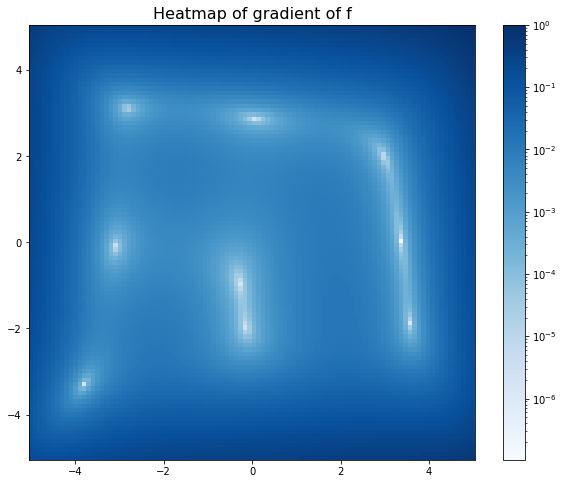

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.pcolormesh(xsf, ysf, heatmap, cmap='Blues', shading='auto', norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.set_title('Heatmap of gradient of f', fontsize=16)
plt.show()

We can clearly see a few critical points (visible as little white-ish dots).

For vector field we will choose fewer points, as 100 of them make it hard to analize this plot.

In [13]:
n_points = 30

xs = np.linspace(-4, 4, n_points)
ys = np.linspace(-4, 4, n_points)
vs = np.meshgrid(xs, ys)
h = 1 / n_points

gradx = derivative(f, vs, h, 'x')
grady = derivative(f, vs, h, 'y')

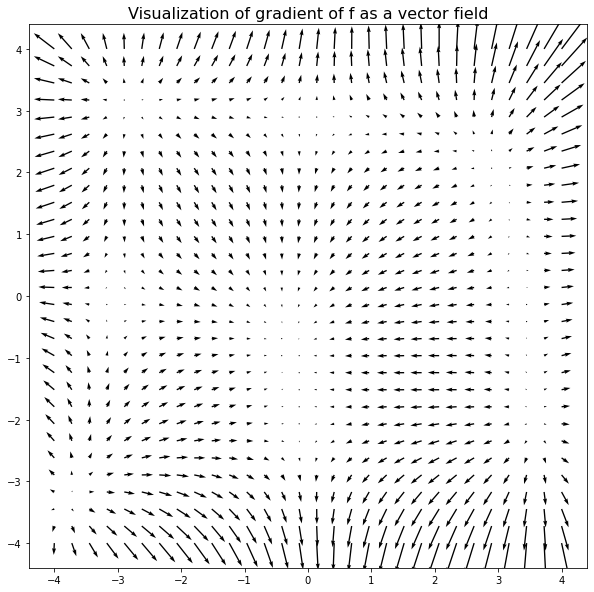

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.quiver(xs, ys, gradx, grady)
ax.set_title('Visualization of gradient of f as a vector field', fontsize=16)
plt.show()

## 2nd task

Now we will aplly **descent without gradient** algorithm.

In [15]:
from itertools import product

In [16]:
def get_neighbours(f, x, y, h):
    """Compute f values for x, y neighbours in a h range."""
    return {
        (u, v): f(u, v) for u, v in product([x, x + h, x - h], [y, y + h, y - h])
    }

In [17]:
def descent_without_gradient(f, min_x, max_x, min_y, max_y, h=0.00001):
    """Apply descent without gradient algorithm.
    
    Parameters
    ----------
    f : function
        Function for which algorithm will be applied.
    min_x : float
    max_x : float
    min_y : float
    max_y : float
    h : float
    """
    
    # randomly choose starting point in a given range
    lowest_x = np.random.uniform(min_x, max_x)
    lowest_y = np.random.uniform(min_y, max_y)
    lowest_value = f(lowest_x, lowest_y)
    
    continuing = True
    # keep all the visited points
    path = [[lowest_x, lowest_y]]

    while continuing:
        neighbours = get_neighbours(f, lowest_x, lowest_y, h)
        # choose only neighbours from a set range
        neighbours = {
            (u, v): neighbours[(u, v)] for u, v in neighbours.keys() if (
                        (min_x <= u <= max_x) and (min_y <= v <= max_y)
            )
        }
        
        lowest_neighbour = sorted(neighbours.items(), key=lambda x: x[1])[0]
        new_x, new_y = lowest_neighbour[0]
        new_value = lowest_neighbour[1]

        if new_value < lowest_value:
            lowest_x, lowest_y = new_x, new_y
            lowest_value = new_value
            path.append([new_x, new_y])
        else:
            continuing = False
    
    return lowest_x, lowest_y, lowest_value, np.array(path)

In [18]:
min_x, max_x, min_y, max_y = -5, 5, -5, 5

In [20]:
x, y, v, path = descent_without_gradient(f, min_x, max_x, min_y, max_y)

In [21]:
print(f'Exemplary result: x={x}, y={y}')

Exemplary result: x=-2.805121983681726, y=3.1313170626953553


## 3rd task

Now we will try to find all minimas of our function.

In [22]:
from scipy.spatial.distance import euclidean

In [26]:
def hessian_matrix(f, x, y, h):
    """Compute Hessian matrix."""
    hessian = np.zeros((2, 2))
    
    hessian[0, 0] = (f(x + h, y) - 2 * f(x, y) + f(x - h, y)) / (h**2)
    hessian[1, 1] = (f(x, y + h) - 2 * f(x, y) + f(x, y - h)) / (h**2)
    
    v = (
        f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)
        ) / (4 * (h)**2)
    hessian[0, 1], hessian[1, 0] = v, v
    
    return hessian

In [27]:
def characterize_point(hessian):
    """Characterize, if critical point is saddle, minimum or maximum."""
    eigvals = np.linalg.eigvals(hessian)
    
    if np.all(eigvals > 0):
        return 'local_min'
    if np.all(eigvals < 0):
        return 'local_max'
    return 'saddle'

In [28]:
def critical_points(f, min_x, max_x, min_y, max_y, h=0.00001, threshold=10e-1, n=100):
    """Find critical points of given function.
    
        
    Parameters
    ----------
    f : function
        Function for which algorithm will be applied.
    min_x : float
    max_x : float
    min_y : float
    max_y : float
    h : float
    threshold : float
        Distance for two points to be considered as different extremas.
    n : int
        Number of iterations, i.e. number of independent starting points.
    """
    
    points = {}
    
    for _ in range(n):
        x, y, v, path = descent_without_gradient(f, min_x, max_x, min_y, max_y)
        
        hessian = hessian_matrix(f, x, y, h)
        characterization = characterize_point(hessian)
        
        if characterization != 'saddle' and all(
            euclidean([x, y], [x2, y2]) >= threshold for x2, y2 in points.keys()
        ):
            points[(x, y)] = {'type': characterization,
                             'value': v,
                             'path': path}

    return points

As we usually don't know, how many minimas are we looking for, we will set threshold value at 0.1, so that points closer to each other (according to Euclidean distance) than 0.1 will be treated as repeats.

In [29]:
points = critical_points(f, min_x, max_x, min_y, max_y, threshold=0.1, h=0.001, n=100)
print(len(points))

4


We found all 4 minimas!

In [30]:
ps = np.array([np.array([x, y]) for x, y in points.keys()])

Let's plot our convergence trajectories.

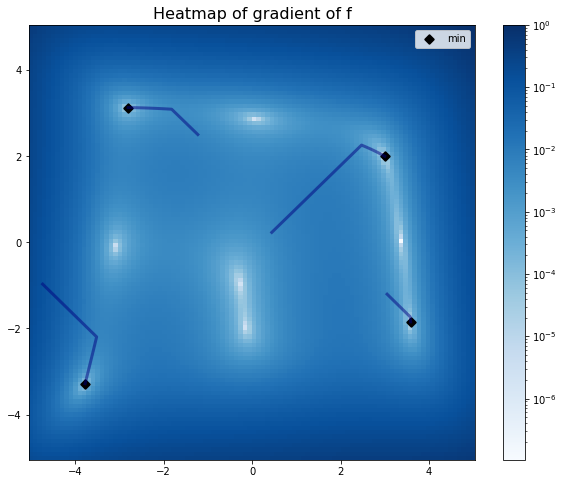

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.pcolormesh(xsf, ysf, heatmap, cmap='Blues', shading='auto',
                  norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.set_title('Heatmap of gradient of f', fontsize=16)

for point in points.keys():
    ax.plot(points[point]['path'][:, 0], points[point]['path'][:, 1], 
            c='navy', linewidth=3, alpha=0.5)

ax.scatter(ps[:, 0], ps[:, 1], marker='D', c='black', linewidth=2, label='min')
ax.legend()
plt.show()